In [76]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Simple Expression

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [3]:
f(3.0)

20.0

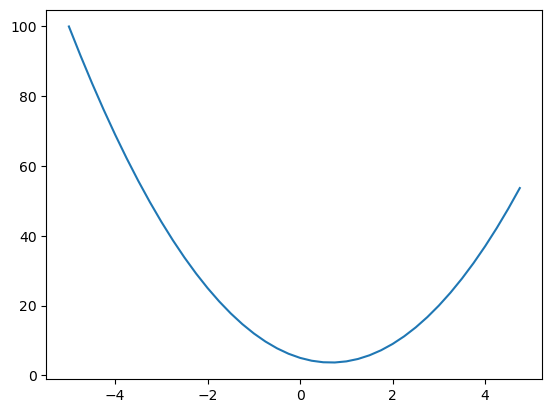

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
h = 0.000001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print('d1', d)
print('d2', d)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0
slope -3.000000000419334


In [84]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward 
        return out
    
    def __mul__(self, other):
    
        if not isinstance(other, Value):
            other = Value(other)
    
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data**other.data, (self, ), f'**{other}')
    
        def _backward():
            self.grad = other.data * (self.data ** (other.data - 1)) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [85]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [88]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [89]:
def lol(h, inc=''):
        
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    if inc in ('a', 'b', 'c', 'f'):
        locals()[inc].data += h
    
    e = a * b; e.label = 'e'
    if(inc == 'e'):
        e.data += h
        
    d = e + c; d.label = 'd'
    if(inc == 'd'):
        d.data += h
        
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
    return a, b, c, d, e, f, L
    
a, b, c, d, e, f, L = lol(h=0.001)

0.0


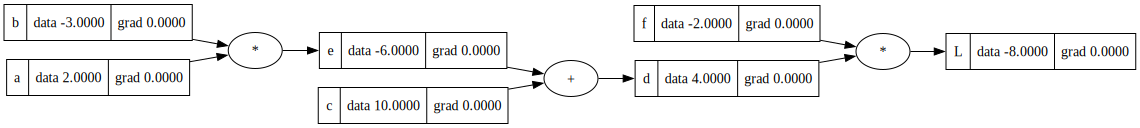

In [90]:
draw_dot(L)

>$df/dx = (f(x+h) - f(x)) / h$

---
- Expressions:

>$L = d * f$

>$d = e + c$

>$e = a * b$

In [91]:
# dL/dL = 1
# dL/dd = ((d + h)*f - (d*f)) / h = (d*f + h*f - d*f) / h = h*f / h = f
# dL/df = d

# dd/dc = (((c + h) + e) - (c + e)) / h = 1.0
# dd/de = dd/dc = 1.0

# de/da = ((a + h) * b - (a * b)) / h = b
# de/db = a

# ---- Chain Rule ----

# dL/dc = (dL/dd) * (dd/dc) = f * (dd/dc)
# dL/de = (dL/dd) * (dd/de) = f * (dd/de)

# dL/da = dL/de * de/da = (dL/dd * dd/de) * de/da
# dL/db = dL/de * de/db = (dL/dd * dd/de) * de/db

L.grad = 1.0
d.grad = f.data
f.grad = d.data
e.grad = d.grad * 1.0
c.grad = d.grad * 1.0
a.grad = e.grad * b.data
b.grad = e.grad * a.data

- From the gradients we can see that:
    - the plus is a distributor of gradient, meaning the gradient from the parent node will just flow to both children with the same value.
    - the multiply propagates the other operand as the gradient to its children.

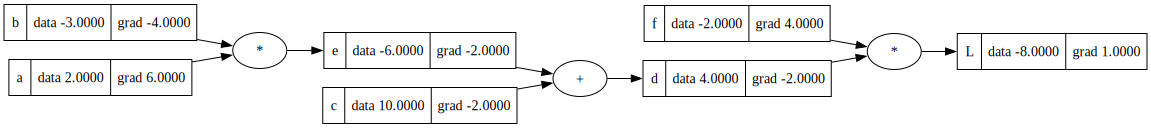

In [92]:
draw_dot(L)

# Single Optimization Step

In [93]:
# No dependencies
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# With dependencies
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [94]:
lol(h=0.001, inc='b')

-3.9999999999995595


(Value(data=2.0),
 Value(data=-2.999),
 Value(data=10.0),
 Value(data=4.002),
 Value(data=-5.998),
 Value(data=-2.0),
 Value(data=-8.004))

# A Neuron

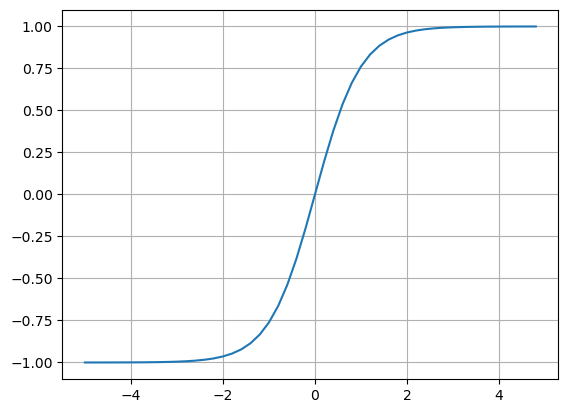

In [95]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [96]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# forward pass
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

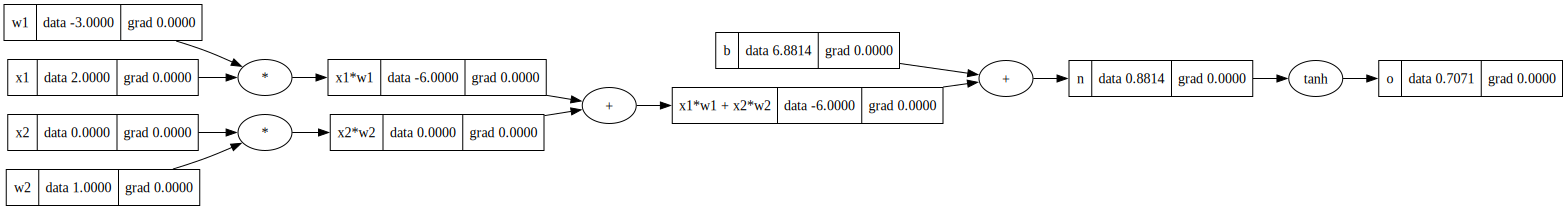

In [97]:
draw_dot(o)

In [98]:
# o = tanh(n)
# do/dn = 1 - o**2
# do/db = do/dn
# do/dx1w1x2w2 = do/dn
# do/x1w1 = do/x1w1x2w2
# do/x2w2 = do/x1w1x2w2
# do/x2 = w2 * do/x2w2
# do/w2 = x2 * do/x2w2
# do/x1 = w1 * do/x1w1
# do/w1 = x1 * do/x1w1

- We need to topologically sort the nodes, so when calculating the gradient the gradient from parent nodes are available, and so nodes are not revisited.

In [99]:
o.backward()

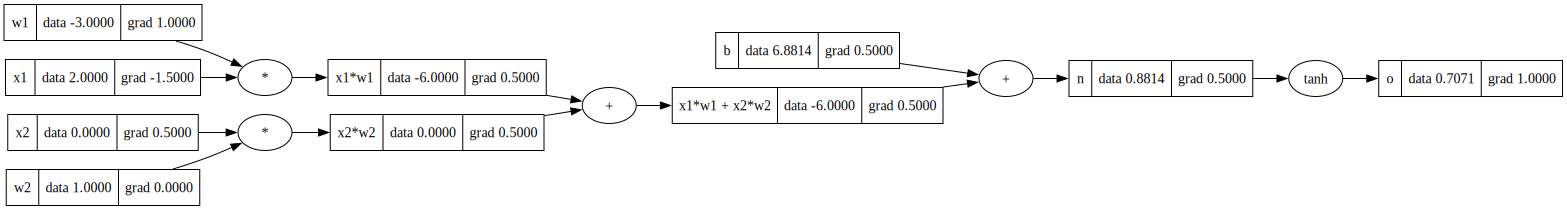

In [100]:
draw_dot(o)

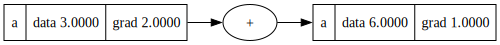

In [101]:
a = Value(3.0, label='a')
b = a + a; b.label = 'a'
b.backward()
draw_dot(b)

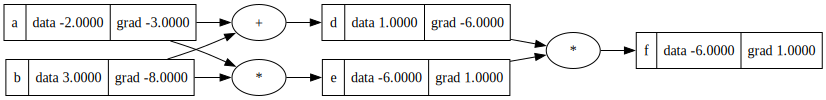

In [102]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a + b; d.label = 'd'
e = a * b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

# Breaking up the tanh

In [103]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# forward pass
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

exp = (2 * n).exp(); exp.label = 'exp'
o = (exp - 1) / (exp + 1)
o.label = 'o'
o.backward()

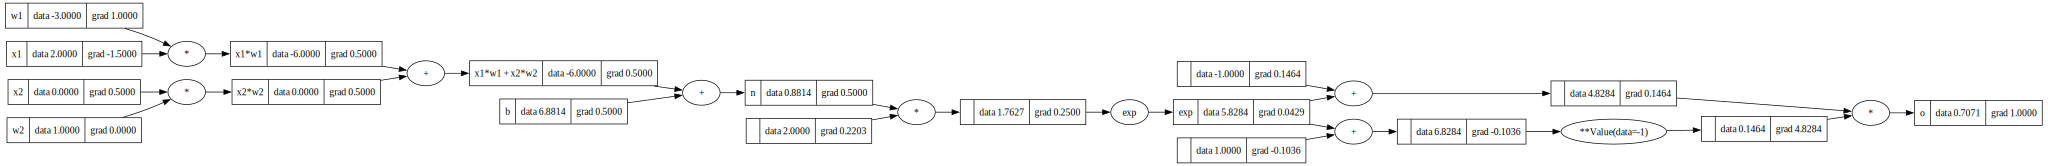

In [104]:
draw_dot(o)

# Doing the same in PyTorch

In [106]:
import torch

In [107]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 1.0000002567688737


# Building a neural net

In [143]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [144]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6273112327270625)

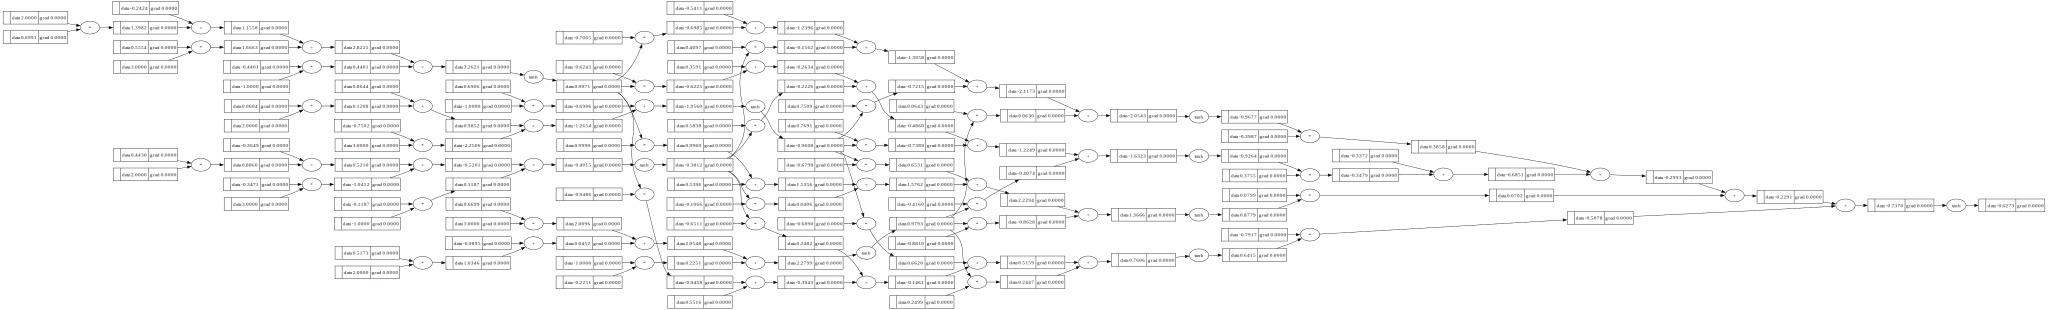

In [146]:
draw_dot(n(x))

# Creating a tiny dataset, writing the loss function

In [351]:
n = MLP(3, [4, 4, 1])

In [352]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [393]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
        p.grad = 0.0
        
    print(k, loss)

0 Value(data=0.0015068115718305654)
1 Value(data=0.0015009824892527385)
2 Value(data=0.0014951971897455875)
3 Value(data=0.0014894551870154994)
4 Value(data=0.0014837560019021591)
5 Value(data=0.0014780991622487098)
6 Value(data=0.0014724842027747436)
7 Value(data=0.0014669106649520158)
8 Value(data=0.0014613780968828994)
9 Value(data=0.0014558860531813478)
10 Value(data=0.001450434094856543)
11 Value(data=0.0014450217891988717)
12 Value(data=0.0014396487096684331)
13 Value(data=0.0014343144357859086)
14 Value(data=0.0014290185530256194)
15 Value(data=0.0014237606527109968)
16 Value(data=0.0014185403319121126)
17 Value(data=0.0014133571933453853)
18 Value(data=0.001408210845275461)
19 Value(data=0.0014031009014189278)


In [394]:
ypred

[Value(data=0.9825697154675089),
 Value(data=-0.9780059562649693),
 Value(data=-0.9854138401903367),
 Value(data=0.9799303197652814)]

In [395]:
# TODO(afonso): Implement this in another notebook using nbdev and the patch decorator to assign methods to classes along the walkthrough to reflect when they were added in th video.
# TODO(afonso): Try to calculate the gradients recursively without topological sorting.
# TODO(afonso): Missing step of calculating the gradients and without the loss function in the whole MLP and see that it does not learn.
# TODO(afonso): Go through the demo in micrograds repo